In [4]:
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import pandas as pd
# import time
import numpy as np
import json
from tqdm.notebook import tqdm

In [41]:
def get_bars(sym, date_range):
    # time     open     high      low    close  tick_volume  spread  real_volume
    a = mt5.copy_rates_range(
        sym,
        mt5.TIMEFRAME_H1, 
        datetime.now() - timedelta(seconds=60*60*24*date_range), 
        datetime.now()
    )
    json.dump([_.tolist() for _ in a], open(datetime.strftime(datetime.now(), '%Y%m%d') + sym + '.json', 'w'))
    print('writing', datetime.strftime(datetime.now(), '%Y%m%d') + sym + '.json')
    return a

def iterate_bars(syms, date_range):
    data = {}
    for sym in tqdm(syms, desc='sym'):
        data[sym] = get_bars(sym, date_range)
    return data

def get_year_range_stats(data, sym):
    
    range_arr = [_[2] - _[3] for _ in data[sym]]
    avg = np.average(range_arr)
    last_100d = np.average(range_arr[-100*24:])
    last_20d = np.average(range_arr[-20*24:])
    std = np.std(range_arr)
    pct1 = np.percentile(range_arr, 0.95)
    pct2 = np.percentile(range_arr, 0.99)
    results = {
        'sym': sym,
        'avg': avg,
        'std': std,
        'pct95': pct1,
        'pct99': pct2,
        'avg+std': avg+std,
        'avg+2std': avg+std+std,
        'last100d': last_100d,
        'last_20d': last_20d
    }
    
    return results

def iterate_year_stats(data):
    results = []
    for sym in tqdm(data.keys(), desc='getting year stats'):
        results.append(get_year_range_stats(data, sym))
    return results

def normalize(data):
    
    # list of dicts
    # multiply by 10000 if it's not /JPY
    
    new_stats = []
    for stat in data:
        row = {'sym': stat['sym']}
        if stat['sym'][3:] == 'JPY':
            mult = 100
        elif 'BTC' in stat['sym'] or 'XAU' in stat['sym'] or 'Index' in stat['sym']:
            mult = 1
        else:
            mult = 10000 
        for _ in [_ for _ in stat.keys() if _ != 'sym']:
            row[_] = stat[_] * mult
        new_stats.append(row)
    return new_stats

In [42]:
if not mt5.initialize():
    mt5.shutdown()
mt5.terminal_info()

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=2981, maxbars=100000, codepage=0, ping_last=184513, community_balance=0.0, retransmission=0.0, company='FX Choice Limited', name='FXChoice MetaTrader 5', language='English', path='C:\\Program Files\\FXChoice MetaTrader 5', ...)

In [43]:
# [_ for _ in a]

In [49]:
syms = [
    'EURUSD', 'USDJPY', 'GBPUSD', 'AUDUSD', 'NZDUSD', 'USDCHF', 'GBPJPY', 'AUDJPY',
    'EURJPY', 'EURGBP', 'EURAUD', 'GBPAUD', 'GBPCHF', 'GBPCAD', 'USDCAD', 'CHFJPY', 'CADJPY', 'NZDJPY',
    'AUDCAD', 'AUDCHF', 'NZDCHF', 'EURNZD', 'EURCHF', 'CADCHF', 'EURCAD', 'GBPNZD', 'NZDCAD', 'AUDNZD',
    'USTECHIndex', 'US500Index', 'XAUUSD', 'BTCUSD',
]
data = iterate_bars(syms, date_range=365)

writing 20210702EURUSD.json
writing 20210702USDJPY.json
writing 20210702GBPUSD.json
writing 20210702AUDUSD.json
writing 20210702NZDUSD.json
writing 20210702USDCHF.json
writing 20210702GBPJPY.json
writing 20210702AUDJPY.json
writing 20210702EURJPY.json
writing 20210702EURGBP.json
writing 20210702EURAUD.json
writing 20210702GBPAUD.json
writing 20210702GBPCHF.json
writing 20210702GBPCAD.json
writing 20210702USDCAD.json
writing 20210702CHFJPY.json
writing 20210702CADJPY.json
writing 20210702NZDJPY.json
writing 20210702AUDCAD.json
writing 20210702AUDCHF.json
writing 20210702NZDCHF.json
writing 20210702EURNZD.json
writing 20210702EURCHF.json
writing 20210702CADCHF.json
writing 20210702EURCAD.json
writing 20210702GBPNZD.json
writing 20210702NZDCAD.json
writing 20210702AUDNZD.json
writing 20210702USTECHIndex.json
writing 20210702US500Index.json
writing 20210702XAUUSD.json
writing 20210702BTCUSD.json



In [50]:
results = iterate_year_stats(data)

In [51]:
final = round(pd.DataFrame(normalize(results)), 2)

In [52]:
final.sort_values('avg').to_csv('1y_risk.csv', index=False)

In [53]:
pd.read_csv('1y_risk.csv')

,sym,avg,std,pct95,pct99,avg+std,avg+2std,last100d,last_20d
0,XAUUSD,5.49,3.99,1.26,1.27,9.48,13.47,4.64,4.50
1,EURCHF,8.55,5.21,2.00,2.04,13.75,18.96,8.42,6.70
2,CADCHF,9.03,5.14,2.30,2.30,14.17,19.30,9.37,8.07
3,US500Index,10.00,7.79,1.74,1.77,17.79,25.58,8.69,5.97
4,NZDCHF,10.31,5.17,3.40,3.40,15.48,20.65,10.52,8.96
5,USDJPY,10.60,6.75,2.80,2.80,17.35,24.10,10.72,9.62
6,USDCHF,10.64,6.82,2.40,2.40,17.46,24.27,10.58,9.76
7,AUDCHF,10.77,5.39,3.40,3.40,16.16,21.54,10.58,8.32
8,EURGBP,11.03,7.57,2.40,2.40,18.60,26.17,9.10,8.14
9,AUDNZD,11.17,5.59,4.10,4.10,16.76,22.35,10.54,9.40


In [55]:
np.percentile([_[2] - _[3] for _ in data['BTCUSD']], 0.99)

18.86674000000012

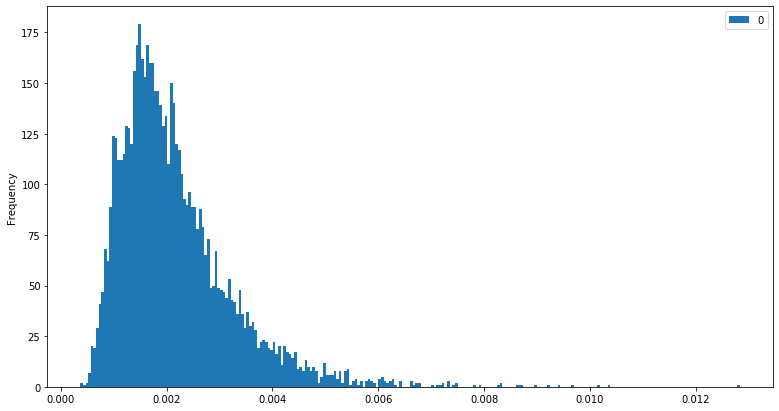

In [58]:
pd.DataFrame([_[2] - _[3] for _ in data['EURAUD']]).plot(kind='hist', bins=250, figsize=(13, 7))

In [38]:
### Loading backed up candles
# json.dump([_.tolist() for _ in a], open('test.json', 'w'))
# json.load(open('test.json', 'r'))